In [ ]:
%matplotlib inline 
# plots graphs within the notebook
%config InlineBackend.figure_format='svg' # not sure what this does, may be default images to svg format

from IPython.display import display,Image, Latex
from __future__ import division
from sympy.interactive import printing
printing.init_printing(use_latex='mathjax')
from IPython.display import clear_output

import time

from IPython.display import display,Image, Latex

from IPython.display import clear_output


import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.constants as sc
import h5py

import sympy as sym

    
font = {'family' : 'serif',
        #'color'  : 'black',
        'weight' : 'normal',
        'size'   : 12,
        }
fontlabel = {'family' : 'serif',
        #'color'  : 'black',
        'weight' : 'normal',
        'size'   : 16,
        }

from matplotlib.ticker import FormatStrFormatter
plt.rc('font', **font)

class PDF(object):
  def __init__(self, pdf, size=(200,200)):
    self.pdf = pdf
    self.size = size

  def _repr_html_(self):
    return '<iframe src={0} width={1[0]} height={1[1]}></iframe>'.format(self.pdf, self.size)

  def _repr_latex_(self):
    return r'\includegraphics[width=1.0\textwidth]{{{0}}}'.format(self.pdf)

class ListTable(list):
    """ Overridden list class which takes a 2-dimensional list of 
        the form [[1,2,3],[4,5,6]], and renders an HTML Table in 
        IPython Notebook. """
    
    def _repr_html_(self):
        html = ["<table>"]
        for row in self:
            html.append("<tr>")
            
            for col in row:
                html.append("<td>{0}</td>".format(col))
            
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)
    

<h1>Python notebook to read atmospheric and soil data</h1>

This notebook uses openpyxl and pandas library

In [2]:
import openpyxl as pyxl

wb = pyxl.load_workbook("data/CraftsburyData6_11_17-10_2_17.xlsx")

print(wb.get_sheet_names())
atmlog = wb.get_sheet_by_name('Sheet1')
atmlog.title
atmlog['A1'].value

['Sheet1']


/Users/dubief/anaconda/lib/python3.5/site-packages/openpyxl/reader/worksheet.py:310: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


'Time (UTC)'

In [9]:
wb = pyxl.load_workbook("data/SN 20146541 2017-09-19 16_16_12 -0400.xlsx")
print(wb.get_sheet_names())
soil1 = wb.get_sheet_by_name("DATA")

['DATA', 'Event Data', 'Details']


In [10]:
rows = atmlog.max_row
print(rows)
columns = atmlog.max_column
print(columns)

T_air = []
date_air = []
i = 0
for rowOfCellObjects in atmlog['I2':'I'+str(rows)]:
    for cellObj in rowOfCellObjects:
#         print(cellObj.coordinate, cellObj.value)
        T_air.append(cellObj.value)
for rowOfCellObjects in atmlog['A2':'A'+str(rows)]:
    for cellObj in rowOfCellObjects:
#         print(cellObj.coordinate, cellObj.value)
        date_air.append(cellObj.value)


10787
13


In [38]:
rows = soil1.max_row
print(rows)
columns = soil1.max_column
print(columns)

T_soil1_1 = []
T_soil1_2 = []
date_soil1 = []
i = 0
for rowOfCellObjects in soil1['C4':'C'+str(rows)]:
    for cellObj in rowOfCellObjects:
#         print(cellObj.coordinate, cellObj.value)
        T_soil1_1.append(cellObj.value)
for rowOfCellObjects in soil1['D4':'D'+str(rows)]:
    for cellObj in rowOfCellObjects:
#         print(cellObj.coordinate, cellObj.value)
        T_soil1_2.append(cellObj.value)
for rowOfCellObjects in soil1['B4':'B'+str(rows)]:
    for cellObj in rowOfCellObjects:
#         print(cellObj.coordinate, cellObj.value)
        date_soil1.append(cellObj.value)


7222
4


In [39]:
from matplotlib.dates import WEEKLY, MONTHLY, DAILY, DateFormatter, rrulewrapper, RRuleLocator, drange
import numpy as np
import datetime
from scipy.constants import convert_temperature
# print(T)
T_air_interp = np.asarray(T_air)
mask = (T_air_interp == np.array(None))
# Tmask = np.where(T_C == None)
T_air_interp[mask] = 0.
for i in range(len(T_air_interp)):
    if mask[i]:
        T_air_interp[i] = T_air_interp[i-1] # not the best way to fill the missing data, will code interpolation later
T_air_interp = convert_temperature(T_air_interp,'Fahrenheit','Celsius')
# print(T_C)
rule = rrulewrapper(WEEKLY)
loc = RRuleLocator(rule)
formatter = DateFormatter('%m/%d/%y')

T_soil1_1 = np.asarray(T_soil1_1)
T_soil1_2 = np.asarray(T_soil1_2)
print(T_soil1_1.shape)




(7219,)


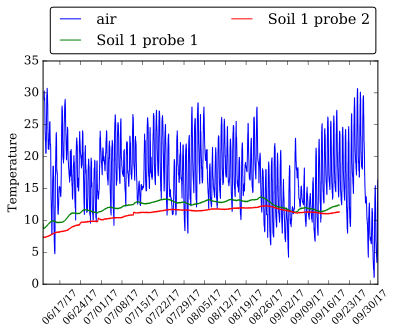

In [40]:

fig, ax = plt.subplots()
plt.plot(date_air, T_air_interp, label = r"air")
plt.plot(date_soil1,T_soil1_1, label = r"Soil 1 probe 1")
plt.plot(date_soil1,T_soil1_2, label = r"Soil 1 probe 2")
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(formatter)
labels = ax.get_xticklabels()
plt.setp(labels, rotation=45, fontsize=10)
plt.ylabel(r"Temperature")
plt.legend(loc=3, bbox_to_anchor=[0, 1.], ncol=2, shadow=False, fancybox=True)
plt.show()

In [61]:
# Hourly averages
import pandas as pd

# Create an empty dataframe
df_air = pd.DataFrame()

# Create a column from the datetime variable
df_air['datetime'] = date_air
# Convert that column into a datetime datatype
df_air['datetime'] = pd.to_datetime(df_air['datetime'])
# Set the datetime column as the index
df_air.index = df_air['datetime'] 
# Create a column from the numeric score variable
df_air['temperature'] = T_air_interp

df_air['temperature'] = df_air['temperature'].astype(float)
df_air.resample('D').mean()


,temperature
datetime,
2017-06-11,29.185897
2017-06-12,25.504051
2017-06-13,22.949074
2017-06-14,14.227431
2017-06-15,13.988304
2017-06-16,14.413773
2017-06-17,19.059606
2017-06-18,23.678241
2017-06-19,21.990741


In [62]:
# Hourly averages
import pandas as pd

# Create an empty dataframe
df_soil1_1 = pd.DataFrame()

# Create a column from the datetime variable
df_soil1_1['datetime'] = date_soil1
# Convert that column into a datetime datatype
df_soil1_1['datetime'] = pd.to_datetime(df_soil1_1['datetime'])
# Set the datetime column as the index
df_soil1_1.index = df_soil1_1['datetime'] 
# Create a column from the numeric score variable
df_soil1_1['temperature'] = T_soil1_1

df_soil1_1['temperature'] = df_soil1_1['temperature'].astype(float)
df_soil1_1.resample('D').mean()


,temperature
datetime,
2017-06-11,8.798957
2017-06-12,9.074234
2017-06-13,9.558055
2017-06-14,9.897088
2017-06-15,9.816053
2017-06-16,9.684969
2017-06-17,9.710590
2017-06-18,9.890533
2017-06-19,10.360650


In [59]:
print(np.shape(df_soil1_1.resample('H').mean()))
T_soil1_1_H = np.asarray(df_soil1_1.resample('D').mean())
T_air_H = np.asarray(df_air.resample('D').mean())

(2407, 1)


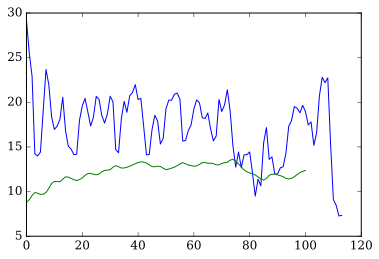

In [60]:
plt.plot(T_air_H)
plt.plot(T_soil1_1_H)

(101, 1)
(101, 1)


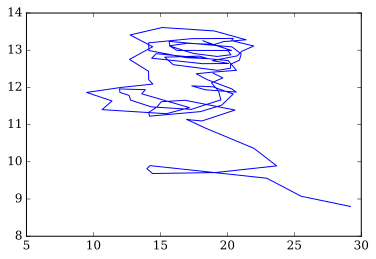

In [68]:
print(np.shape(T_air_H[:101]))
print(np.shape(T_soil1_1_H))
plt.plot(T_air_H[:101],T_soil1_1_H)
